In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import os
from reload_recursive import reload_recursive
import helpers
import pyperclip
import statsmodels.api as sm
import subprocess

from mri_data import file_manager as fm
from mri_data import utils

from monai_training import pr

In [2]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path("/home/srs-9/Projects/ms_mri/analysis/paper1")
data_dir = curr_dir / "data0"
showfigs = False
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.precision = 3

In [3]:
df1 = pd.read_csv(data_dir / "t1_data_full.csv")
df1.set_index('subid', inplace=True)
df1 = helpers.set_dz_type5(df1)

df2 = pd.read_csv(data_dir / "t1_2_data_full.csv")
df2.set_index('subid', inplace=True)
df2 = helpers.set_dz_type5(df2)

df3 = pd.read_csv(data_dir / "t1_3_data_full.csv")
df3.set_index('subid', inplace=True)
df3 = helpers.set_dz_type5(df3)

df_ascho = pd.read_csv(data_dir / "t1_aschoplex_data_full.csv", index_col="subid")

df_flair = pd.read_csv(data_dir / "flair_data_full.csv")
df_flair.set_index('subid', inplace=True)
df_flair = helpers.set_dz_type5(df_flair)

df_t1_flair = pd.read_csv(data_dir / "t1_flair_data_full.csv")
df_t1_flair.set_index('subid', inplace=True)
df_t1_flair = helpers.set_dz_type5(df_t1_flair)

In [4]:
df = pd.DataFrame(index=df1.index)
df['age'] = df1['age']
df['dz_type5'] = df1['dz_type5']
df['pineal_volume1'] = df1['pineal_volume']
df['pineal_volume2'] = df2['pineal_volume']
df['EDSS'] = df1['extracted_EDSS']
df['choroid_volume1'] = df1['choroid_volume']
df['choroid_volume2'] = df2['choroid_volume']
df['choroid_volumeAP'] = df_ascho['choroid_volume']
df['cp_diff'] = df['choroid_volume1'] - df['choroid_volume2']
df['choroid_volume_fl'] = df_flair['choroid_volume']
df['choroid_volume_t1fl'] = df_t1_flair['choroid_volume']

In [5]:
df = df.sort_values(by="cp_diff", ascending=False)
df_pms = df[df['dz_type5']=="PMS"]
df_rms = df[df['dz_type5']=="RMS"]
df_nind = df[df['dz_type5']=="NIND"].sort_values(by="choroid_volume1", ascending=False)
df_oind = df[df['dz_type5']=="OIND"].sort_values(by="choroid_volume1", ascending=False)
df_pms_w = df[(df['dz_type5']=="PMS") & (df1['flair_contrast'] == "WITH")]

/tmp/ipykernel_3962/1759061542.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pms_w = df[(df['dz_type5']=="PMS") & (df1['flair_contrast'] == "WITH")]


In [7]:
check = df1.sort_values(by="PRL", ascending=False)

In [9]:
sub = 1238

dataroot = drive_root / "3Tpioneer_bids"
labelroot = drive_root / "srs-9/3Tpioneer_bids_predictions"
label1 = labelroot / df1.loc[sub, 'sub-ses'] / df1.loc[sub, 'label']
label2 = labelroot / df2.loc[sub, 'sub-ses'] / df2.loc[sub, 'label']
labelAP = Path(df_ascho.loc[sub, 'label_folder']) / df_ascho.loc[sub, 'label']
label_flair = labelroot / df_flair.loc[sub, 'sub-ses'] / df_flair.loc[sub, 'label']
label_t1_flair = labelroot / df_t1_flair.loc[sub, 'sub-ses'] / df_t1_flair.loc[sub, 'label']

man_pineal = dataroot / df1.loc[sub, 'sub-ses'] / "pineal-SRS.nii.gz"
man_pineal2 = dataroot / df1.loc[sub, 'sub-ses'] / "pineal-SRS_T1.nii.gz"


t1 = dataroot / df1.loc[sub, 'sub-ses'] / "t1.nii.gz"
t1_gd = dataroot / df1.loc[sub, 'sub-ses'] / "t1_gd.nii.gz"

flair = dataroot / df1.loc[sub, 'sub-ses'] / "flair.nii.gz"
t1_gd = dataroot / df1.loc[sub, 'sub-ses'] / "t1_gd.nii.gz"
phase = dataroot / df1.loc[sub, 'sub-ses'] / "phase.nii.gz"

images = []
# for im in [t1, t1_gd, flair, phase]:
for im in [flair, phase]:
    if im.exists():
        images.append(im)

labels = []
for lab in [label1, labelAP]:
    if lab.exists():
        labels.append(lab)

cmd = utils.open_itksnap_workspace_cmd(images=images, labels=labels, win=True)
pyperclip.copy(cmd)
print(cmd)
subprocess.Popen(cmd.split(" "))

itksnap -g H:/3Tpioneer_bids/sub-ms1238/ses-20190621/flair.nii.gz -o H:/3Tpioneer_bids/sub-ms1238/ses-20190621/phase.nii.gz -s H:/srs-9/3Tpioneer_bids_predictions/sub-ms1238/ses-20190621/t1_choroid_pineal_pituitary_T1-1_pred.nii.gz H:/srs-9/aschoplex/test1_inference/MRI_1238_image_ensemble_seg.nii.gz


In [21]:
man_pineal2.exists()

False

In [14]:
sub = 1272
t1 = dataroot / df1.loc[sub, 'sub-ses'] / "proc/t1_std.nii.gz"
flair = dataroot / df1.loc[sub, 'sub-ses'] / "proc/flair_std.nii.gz"
t1_std = dataroot / df1.loc[sub, 'sub-ses'] / "proc/t1_gd_std.nii.gz"
cmd = utils.open_itksnap_workspace_cmd(images=[t1, flair, t1_std], win=True)
# subprocess.Popen(cmd.split(" "))
print(cmd)
pyperclip.copy(cmd)

itksnap -g H:/3Tpioneer_bids/sub-ms1272/ses-20211105/proc/t1_std.nii.gz -o H:/3Tpioneer_bids/sub-ms1272/ses-20211105/proc/flair_std.nii.gz H:/3Tpioneer_bids/sub-ms1272/ses-20211105/proc/t1_gd_std.nii.gz


In [190]:
model_data = df2.copy()
# model_data.loc[model_data['dz_type5']=="PMS", "choroid_volume"] = df.loc[df['dz_type5']=="PMS", "choroid_volume1"]
# subs_to_change = [1453, 1276, 1370, 1049, 1077, 1299, 1155, 2027, 1322]
subs_to_change = [1530, 1435, 1442, 1106, 1068, 2051, 1052, 1217, 1049, 1508]
model_data.loc[subs_to_change, "choroid_volume"] = df.loc[subs_to_change, "choroid_volume1"]

model_data = helpers.fix_edss(model_data)
model_data = helpers.clean_df(model_data)

model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
model_data = pd.concat((model_data, pd.get_dummies(model_data["sex"], dtype="int")), axis=1)

model_data['EDSS'] = model_data['EDSS'].astype("float")

In [191]:
res = sm.OLS.from_formula("EDSS ~ choroid_volume + tiv + age + Female", data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   EDSS   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     25.24
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           1.28e-18
Time:                        11:37:02   Log-Likelihood:                -785.53
No. Observations:                 397   AIC:                             1581.
Df Residuals:                     392   BIC:                             1601.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9414      1.429      0.

In [192]:
model_data = df1.copy()
model_data = helpers.fix_edss(model_data)
model_data = helpers.clean_df(model_data)

model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
model_data = pd.concat((model_data, pd.get_dummies(model_data["sex"], dtype="int")), axis=1)
model_data['EDSS'] = model_data['EDSS'].astype("float")
res = sm.OLS.from_formula("EDSS ~ choroid_volume + tiv + age + Female", data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   EDSS   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     25.94
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           4.31e-19
Time:                        11:37:33   Log-Likelihood:                -784.41
No. Observations:                 397   AIC:                             1579.
Df Residuals:                     392   BIC:                             1599.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9531      1.423      0.

In [210]:
check = model_data.loc[model_data['EDSS'].dropna().index, :]

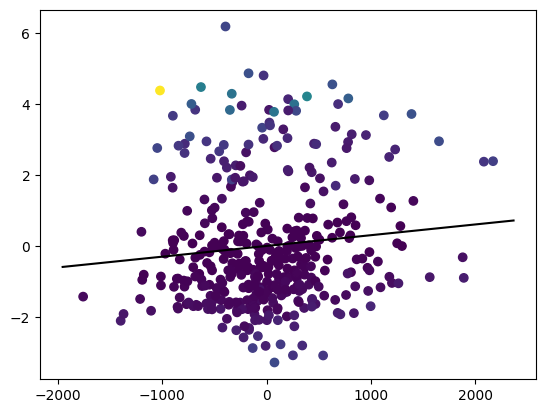

In [37]:
influence = res.get_influence()
cooks_d = influence.cooks_distance
cooks_d[1]

fig = sm.graphics.plot_partregress_grid(res, exog_idx=["choroid_volume"])
ax = fig.get_axes()[0]
lines1 = ax.lines[0]
lines2 = ax.lines[1]
plt.close()
plt.plot(lines2.get_xdata(), lines2.get_ydata(), c=[0,0,0])
plt.scatter(lines1.get_xdata(), lines1.get_ydata(), c=cooks_d[0])

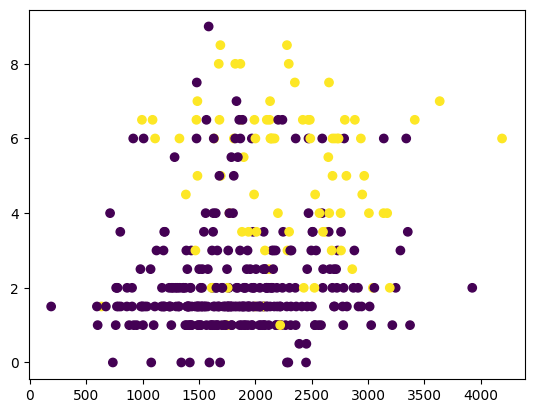

In [ ]:
plt.scatter(model_data["choroid_volume"], model_data["EDSS"], c=model_data['dz_type5C'])

In [156]:
df1.loc[1491, 'flair_contrast']

'WITH'

In [18]:
print(t1)

/media/smbshare/3Tpioneer_bids/sub-ms1370/ses-20210421/proc/t1_std.nii.gz


In [ ]:
fig, axs = plt.subplots(2,1,figsize=(12, 4))

axs[0].hist(df1.loc[df1['dz_type5'].isin(["RMS", "PMS"]), 'choroid_volume'])
axs[1].hist(df3.loc[df2['dz_type5'].isin(["RMS", "PMS"]), 'choroid_volume'])

In [ ]:
plt.scatter(df1.loc[df1['dz_type5'].isin(["RMS", "PMS"]), 'choroid_volume'], 
            df3.loc[df3['dz_type5'].isin(["RMS", "PMS"]), 'choroid_volume'])

In [ ]:
plt.hist((df1.loc[df1['dz_type5'].isin(["PMS"]), 'choroid_volume'] - df2.loc[df2['dz_type5'].isin(["PMS"]), 'choroid_volume']))